## TSML-13_HW4_GARCH

Задание: Выберите ряд из первого задания и постройте его модель GARCH. Отчет нужно будет оформить в jupyter-ноутбук.

In [15]:
import pandas as pd
import numpy as np
import tqdm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

from arch import arch_model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from math import sqrt

#### Берем ряд изменения среднемесячной температуры ("Mean monthly air temperature (Deg. F) Nottingham Castle")

In [3]:
series = pd.read_csv("./data/HW1/mean-monthly-air-temperature-deg.csv")['Deg']

#### Задаем функцию для проведения теста Дики-Фуллера

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#### Задаем функцию вывода коррелограмм

In [6]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

#### Проверка на стационарность по тесту Дики-Фуллера и посмотр коррелограммы

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


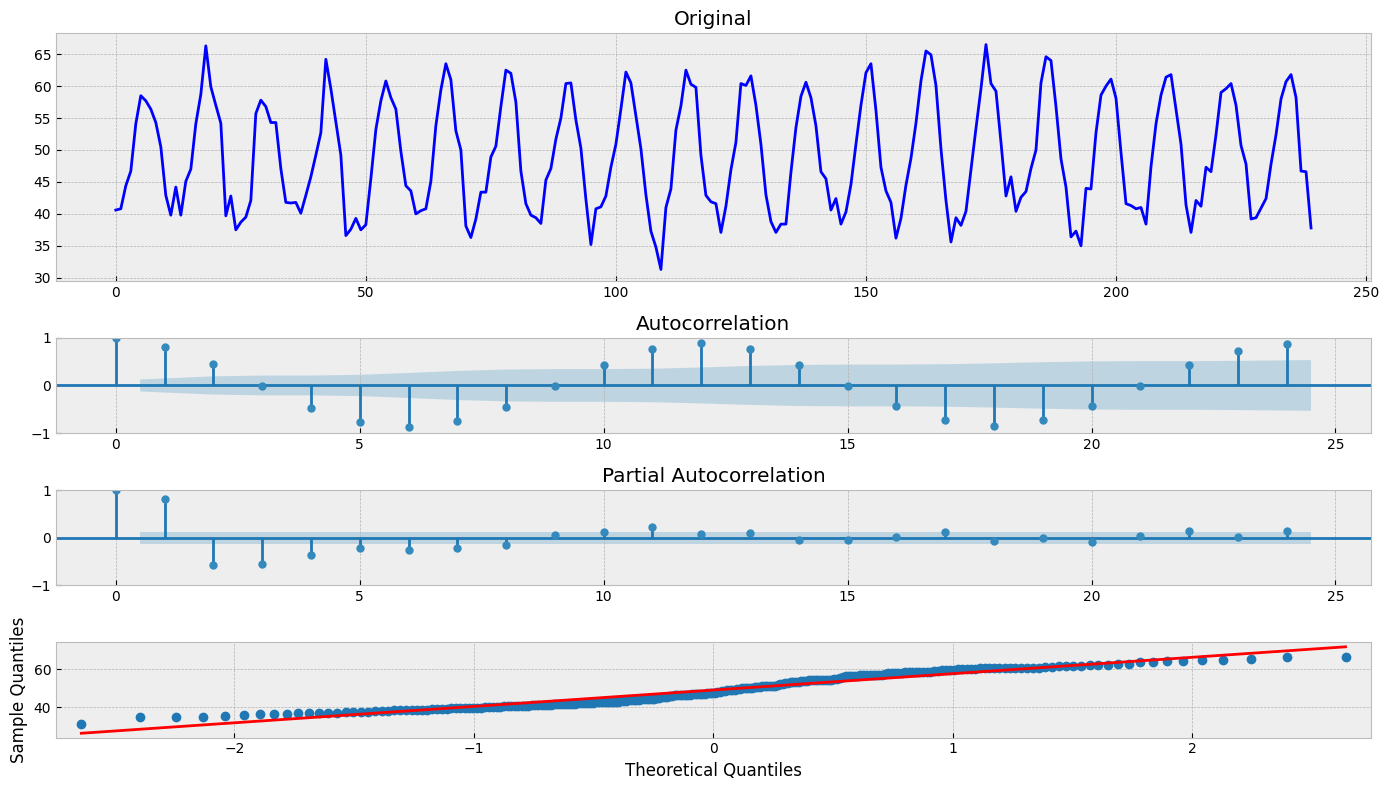

In [8]:
tsplot(series)

#### p-value меньше 0.05
#### Присутствует сезонность
#### Ряд не является стационарным


#### Построим модель ARIMA для получения оптимальных параметров p, o, q. [При этом обучим модель ARIMA на изначальном (нестационарном) ряде, т.к. в ARIMA заложены механизмы работы именно с нестационарными рядами.]

aic: 1136.11316 | order: (3, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                  -5.624780
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


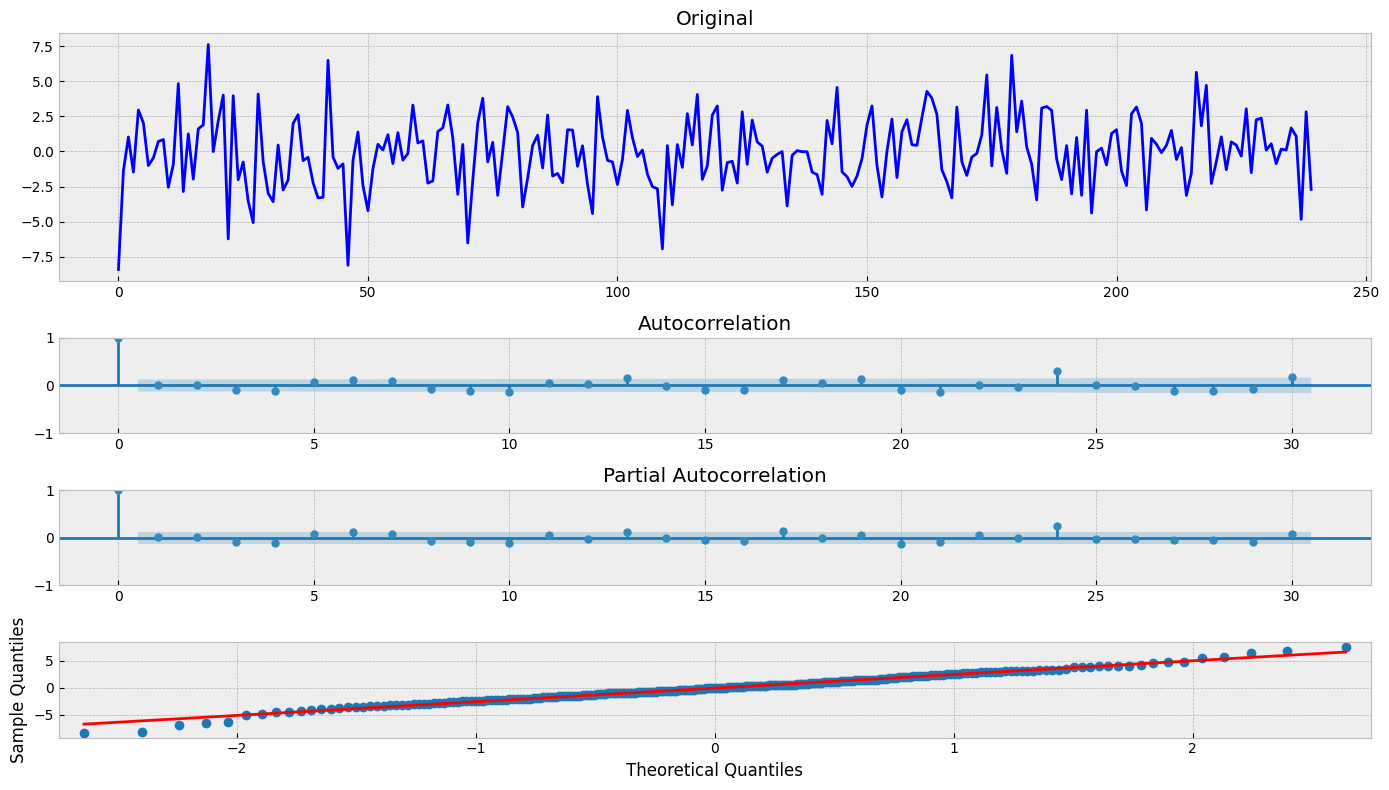

In [11]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                model = sm.tsa.arima.ARIMA(series, order=(i,d,j))
                tmp_mdl = model.fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic                
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

tsplot(best_mdl.resid, lags=30)

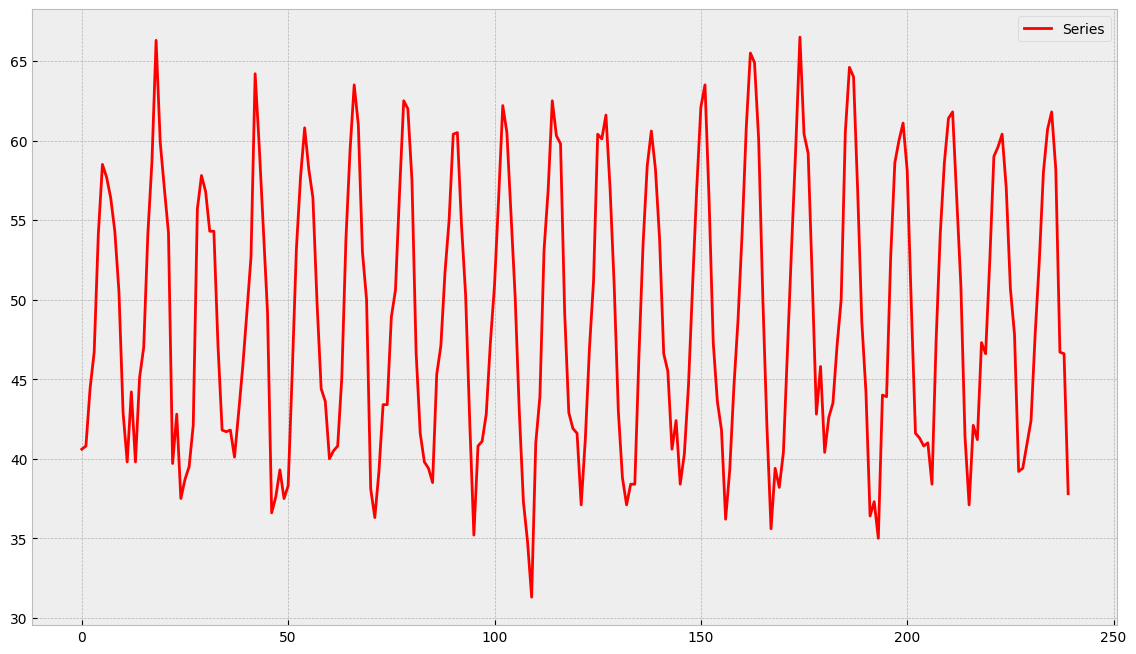

In [13]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.predict(1, len(series)+50, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

#### Модель ARIMA подобрала оптимальные параметры 'p', 'o' и 'q':  (3, 0, 2)

## Построение модели GARCH на этих параметрах.

In [16]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 3
o_ = 0
q_ = 2

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          Deg   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -844.976
Distribution:      Standardized Student's t   AIC:                           1705.95
Method:                  Maximum Likelihood   BIC:                           1733.80
                                              No. Observations:                  240
Date:                      Sat, Dec 02 2023   Df Residuals:                      239
Time:                              17:10:23   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            45

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


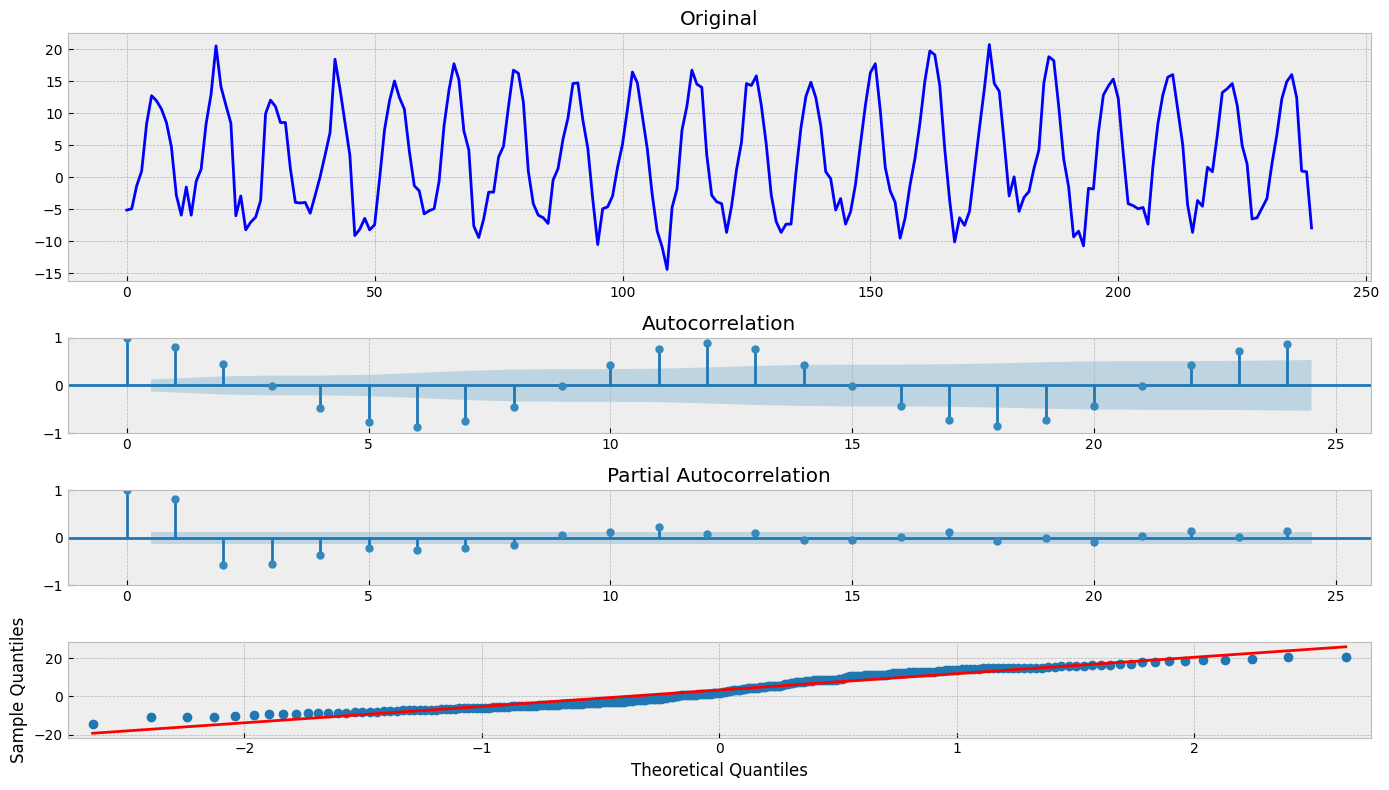

In [17]:
tsplot(res.resid)